In [16]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split , StratifiedKFold , GridSearchCV , cross_val_score , cross_val_predict ,KFold
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix  , classification_report ,recall_score , precision_score , f1_score, roc_auc_score , roc_curve
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.experimental import enable_iterative_imputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import optuna


In [2]:
df = pd.read_csv('pima-indians-diabetes.csv')
df.columns = ['preg' , 'glucose' , 'BP' ,'skin' , 'insulin' ,'BMI','DPF' , 'age','class']
df

,preg,glucose,BP,skin,insulin,BMI,DPF,age,class
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,0
763,2,122,70,27,0,36.8,0.340,27,0
764,5,121,72,23,112,26.2,0.245,30,0
765,1,126,60,0,0,30.1,0.349,47,1


In [3]:
def null_fun (x):
    df[x] = df[x].replace(0,np.nan)
    
null_cols = ['glucose' , 'BP' , 'skin' , 'insulin' , 'BMI']
for col in null_cols:
    null_fun(col)    

In [4]:
null_cols = ['glucose' , 'BP' , 'skin' , 'insulin' , 'BMI']
for col in null_cols:
    null_fun(col)

In [5]:
df['insulin'] = df['insulin'].apply(lambda x : round(df[df['insulin']<350]['insulin'].mean(),0) if x>380 else x)

In [6]:
df_mv = pd.DataFrame(df.isnull().sum() , columns = ['count MV'])
df_mv = df_mv[df_mv['count MV']>0]
df_mv = df_mv.sort_values(by = 'count MV' , ascending = False)

In [7]:
for col in df_mv.index.tolist():
    df[col] = df.groupby('class')[col].transform(lambda value : value.fillna(value.median()))

In [8]:
df.isnull().sum()

preg       0
glucose    0
BP         0
skin       0
insulin    0
BMI        0
DPF        0
age        0
class      0
dtype: int64

# LightGBM with gridsearch

In [9]:
X = df.drop('class' , axis = 1)
y = df['class']


oversample = SMOTE(k_neighbors=2 , random_state = 101)
X_balanced, y = oversample.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_balanced, y, test_size=0.3, random_state=101)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
param_grid = {'num_leaves': [5, 10, 15, 20],
    'min_data_in_leaf': [5, 10, 15, 20],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]}

In [11]:
# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()



k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search_LG = GridSearchCV(lgb_classifier, param_grid, cv=k_fold,scoring='recall', verbose=1, n_jobs=-1)
grid_search_LG.fit(X_train, y_train)

# Print the best hyperparameters found by grid search
print("Best hyperparameters:", grid_search_LG.best_params_)

# Get the best model with the tuned hyperparameters
grid_search_LG = grid_search_LG.best_estimator_

# Make predictions on the test data using the best model
y_pred_LG = grid_search_LG.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_LG)
confusion = confusion_matrix(y_test, y_pred_LG)
report = classification_report(y_test, y_pred_LG)

# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Best hyperparameters: {'lambda_l1': 0.1, 'lambda_l2': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_data_in_leaf': 5, 'num_leaves': 10}
Accuracy: 0.91
Confusion Matrix:
 [[125  17]
 [ 10 148]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       142
           1       0.90      0.94      0.92       158

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



In [12]:
fp = np.sum((grid_search_LG.predict(X_test) == 1) & (y_test == 0))
fn = np.sum((grid_search_LG.predict(X_test) == 0) & (y_test == 1))
tn = np.sum((grid_search_LG.predict(X_test) == 0) & (y_test == 0))
tp = np.sum((grid_search_LG.predict(X_test) == 1) & (y_test == 1))

FPR = fp/(fp+tn)
FNR = fn/(fn+tp)

print(classification_report(y_test , grid_search_LG.predict(X_test)))

print('specifity',recall_score(np.logical_not(y_test) , np.logical_not(grid_search_LG.predict(X_test))))
print('AUC : ',roc_auc_score(y_test , grid_search_LG.predict(X_test)))
print('FPR :' , FPR )
print('FNR :' , FNR )

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       142
           1       0.90      0.94      0.92       158

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

specifity 0.8802816901408451
AUC :  0.9084952754501694
FPR : 0.11971830985915492
FNR : 0.06329113924050633


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

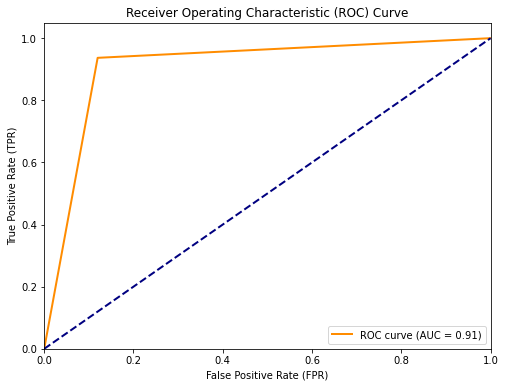

In [14]:


# Assuming you have true labels (y_true) and predicted probabilities (y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LG)
roc_auc = roc_auc_score(y_test, y_pred_LG)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# light with OPTUMA

In [26]:

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_categorical("num_leaves", [5, 10, 15, 20]),
        "min_data_in_leaf": trial.suggest_categorical("min_data_in_leaf", [5, 10, 15, 20]),
        "max_depth": trial.suggest_categorical("max_depth", [3, 5, 7, 10]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "lambda_l1": trial.suggest_categorical("lambda_l1", [0, 0.1, 0.5]),
        "lambda_l2": trial.suggest_categorical("lambda_l2", [0, 0.1, 0.5]),
    }
    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_test, label=y_test)

    # Train a LightGBM model
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], early_stopping_rounds=100, verbose_eval=False)

    # Make predictions on the validation set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, np.round(y_pred))

    return 1 - accuracy  # Optuna minimizes the objective function, so we use (1 - accuracy)

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final LightGBM model with the best hyperparameters
final_params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    **best_params  # Include the best hyperparameters
}

final_model = lgb.train(final_params, lgb.Dataset(X_train, label=y_train), verbose_eval=False)

# Make predictions on your test dataset
# Replace test_data with your test dataset
test_predictions = final_model.predict(X_test)

# Optionally, evaluate the final model on a separate test set and report metrics
# test_accuracy = accuracy_score(test_labels, np.round(test_predictions))
# print("Test Accuracy:", test_accuracy)


[I 2023-09-12 12:08:06,348] A new study created in memory with name: no-name-b4ce781e-e808-4a46-a9e9-ad1f1086edc2
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Numb

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Numb

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-09-12 12:08:07,125] Trial 15 finished with value: 0.09333333333333338 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 3, 'learning_rate': 0.1918143786861738, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] N

[I 2023-09-12 12:08:08,059] Trial 29 finished with value: 0.09999999999999998 and parameters: {'num_leaves': 15, 'min_data_in_leaf': 15, 'max_depth': 7, 'learning_rate': 0.09674681844146352, 'lambda_l1': 0.1, 'lambda_l2': 0.1}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-09-12 12:08:08,261] Trial 32 finished with value: 0.09999999999999998 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 3, 'learning_rate': 0.14158473171136476, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Numb

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Numb

[I 2023-09-12 12:08:09,073] Trial 45 finished with value: 0.09333333333333338 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 15, 'max_depth': 3, 'learning_rate': 0.07632897384459086, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-09-12 12:08:09,502] Trial 52 finished with value: 0.07999999999999996 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 3, 'learning_rate': 0.13354601813677353, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\ligh

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] N

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[Light

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] N

[I 2023-09-12 12:08:10,818] Trial 72 finished with value: 0.08999999999999997 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 3, 'learning_rate': 0.1490187416554456, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] N

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] N

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-09-12 12:08:12,369] Trial 95 finished with value: 0.09333333333333338 and parameters: {'num_leaves': 10, 'min_data_in_leaf': 20, 'max_depth': 3, 'learning_rate': 0.09179736565320669, 'lambda_l1': 0.5, 'lambda_l2': 0}. Best is trial 8 with value: 0.07666666666666666.
<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-26-d31096938e3e>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Atena\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Info] Number of positive: 342, number of negative: 358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488571 -> initscore=-0.045722
[LightGBM] [Info] Start training from score -0.045722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [144]:
fp = np.sum((model1.predict(X_test) == 1) & (y_test == 0))
fn = np.sum((model1.predict(X_test) == 0) & (y_test == 1))
tn = np.sum((model1.predict(X_test) == 0) & (y_test == 0))
tp = np.sum((model1.predict(X_test) == 1) & (y_test == 1))

FPR = fp/(fp+tn)
FNR = fn/(fn+tp)

print(classification_report(y_test , model1.predict(X_test)))

print('specifity',recall_score(np.logical_not(y_test) , np.logical_not(model1.predict(X_test))))
print('AUC : ',roc_auc_score(y_test , model1.predict(X_test)))
print('FPR :' , FPR )
print('FNR :' , FNR )

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       142
           1       0.90      0.96      0.93       158

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300

specifity 0.8873239436619719
AUC :  0.9215100730968087
FPR : 0.11267605633802817
FNR : 0.04430379746835443


In [25]:
import optuna

In [27]:
#test_predictions = final_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1)
y_pred_binary = np.round(test_predictions)

# Generate the classification report
classification_rep = classification_report(y_test, y_pred_binary)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       142
           1       0.90      0.96      0.93       158

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



In [34]:
#from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
roc_auc = roc_auc_score(y_test, test_predictions)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Calculate FPR, FNR, and Specificity
fpr_value = fp / (fp + tn)
fnr_value = fn / (fn + tp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_test, y_pred_binary)



# Print the results
print("False Positive Rate (FPR): {:.4f}".format(fpr_value))
print("False Negative Rate (FNR): {:.4f}".format(fnr_value))
print("Area Under the Curve (AUC): {:.4f}".format(roc_auc))
print("Specificity (True Negative Rate): {:.4f}".format(specificity))
print("Accuracy: {:.4f}".format(accuracy))


False Positive Rate (FPR): 0.1127
False Negative Rate (FNR): 0.0443
Area Under the Curve (AUC): 0.9632
Specificity (True Negative Rate): 0.8873
Accuracy: 0.9233


# CatBoost With OPTUMA

In [22]:
from catboost import CatBoostClassifier

In [38]:
param_grid_cat = {
    'iterations': [100, 200, 300],        # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],   # Step size for adapting to data
    'depth': [4, 6, 8],                 # Depth of each tree
    'l2_leaf_reg': [1, 3, 5],           # L2 regularization term
    'border_count': [32, 64, 128],      # Number of splits for numerical features
    'leaf_estimation_method': ['Newton', 'Gradient', 'Exact'],  # Leaf estimation method
    'bagging_temperature': [0.2, 0.5, 0.8],   # Intensity of bagging
    'auto_class_weights': ['Balanced']}


In [41]:
import catboost as cb

In [44]:
# Define the objective function for Optuna to optimize
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
        "border_count": trial.suggest_int("border_count", 32, 256),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 1.0),
    }

    # Create a CatBoost classifier
    model = cb.CatBoostClassifier(**params, verbose=0)

    # Train the CatBoost model
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return 1 - accuracy  # Optuna minimizes the objective function, so we use (1 - accuracy)

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final CatBoost model with the best hyperparameters
final_model = cb.CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X_train, y_train)

# Make predictions on your test dataset
# Replace test_data with your test dataset
test_predictions = final_model.predict(X_test)

# Optionally, evaluate the final model on a separate test set and report metrics
# test_accuracy = accuracy_score(test_labels, test_predictions)
# print("Test Accuracy:", test_accuracy)


[I 2023-09-12 12:46:09,515] A new study created in memory with name: no-name-0f76bd9c-2e06-4700-a079-87325f4f9c5c
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_temperature": trial.suggest_unif

[I 2023-09-12 12:46:13,337] Trial 6 finished with value: 0.12 and parameters: {'iterations': 471, 'learning_rate': 0.19191521033124997, 'depth': 5, 'l2_leaf_reg': 0.5097320690231834, 'border_count': 184, 'bagging_temperature': 0.784584826128703}. Best is trial 0 with value: 0.06999999999999995.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uniform has been deprecat

[I 2023-09-12 12:46:22,119] Trial 13 finished with value: 0.08666666666666667 and parameters: {'iterations': 449, 'learning_rate': 0.010539377943453124, 'depth': 10, 'l2_leaf_reg': 9.372065690957548, 'border_count': 36, 'bagging_temperature': 0.45383097844991}. Best is trial 0 with value: 0.06999999999999995.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uniform ha

[I 2023-09-12 12:46:30,705] Trial 20 finished with value: 0.07999999999999996 and parameters: {'iterations': 281, 'learning_rate': 0.0705145357094359, 'depth': 8, 'l2_leaf_reg': 5.627901573745139, 'border_count': 114, 'bagging_temperature': 0.39260846492753765}. Best is trial 0 with value: 0.06999999999999995.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uniform h

[I 2023-09-12 12:46:39,304] Trial 27 finished with value: 0.07999999999999996 and parameters: {'iterations': 365, 'learning_rate': 0.02116956932589565, 'depth': 10, 'l2_leaf_reg': 3.6381240345898656, 'border_count': 90, 'bagging_temperature': 0.03376693858628704}. Best is trial 0 with value: 0.06999999999999995.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uniform

[I 2023-09-12 12:46:53,587] Trial 34 finished with value: 0.08666666666666667 and parameters: {'iterations': 426, 'learning_rate': 0.06890262642464831, 'depth': 10, 'l2_leaf_reg': 0.7085757623458211, 'border_count': 99, 'bagging_temperature': 0.21555944192663312}. Best is trial 33 with value: 0.06666666666666665.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_unifor

[I 2023-09-12 12:47:06,462] Trial 41 finished with value: 0.06999999999999995 and parameters: {'iterations': 499, 'learning_rate': 0.01225484390218859, 'depth': 9, 'l2_leaf_reg': 0.6092806317480942, 'border_count': 155, 'bagging_temperature': 0.21121461363193184}. Best is trial 36 with value: 0.06000000000000005.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_unifor

[I 2023-09-12 12:47:19,573] Trial 48 finished with value: 0.07666666666666666 and parameters: {'iterations': 477, 'learning_rate': 0.013988006752792766, 'depth': 7, 'l2_leaf_reg': 0.39227203025008617, 'border_count': 190, 'bagging_temperature': 0.05033287271224621}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uni

[I 2023-09-12 12:47:37,263] Trial 55 finished with value: 0.07666666666666666 and parameters: {'iterations': 436, 'learning_rate': 0.019038740688910663, 'depth': 8, 'l2_leaf_reg': 0.0752858614874016, 'border_count': 210, 'bagging_temperature': 0.09466522545621478}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_unif

[I 2023-09-12 12:48:00,457] Trial 62 finished with value: 0.06000000000000005 and parameters: {'iterations': 464, 'learning_rate': 0.01731549877449841, 'depth': 10, 'l2_leaf_reg': 0.0563545187065387, 'border_count': 151, 'bagging_temperature': 0.045691475293972626}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uni

[I 2023-09-12 12:48:30,033] Trial 69 finished with value: 0.05666666666666664 and parameters: {'iterations': 370, 'learning_rate': 0.021883863825772613, 'depth': 10, 'l2_leaf_reg': 0.09494238165878036, 'border_count': 178, 'bagging_temperature': 0.13995325441934178}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_un

[I 2023-09-12 12:48:53,873] Trial 76 finished with value: 0.07333333333333336 and parameters: {'iterations': 288, 'learning_rate': 0.016115572832211326, 'depth': 9, 'l2_leaf_reg': 0.15470093588430622, 'border_count': 118, 'bagging_temperature': 0.061013252378743194}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_un

[I 2023-09-12 12:49:18,587] Trial 83 finished with value: 0.05666666666666664 and parameters: {'iterations': 484, 'learning_rate': 0.017164099883808313, 'depth': 10, 'l2_leaf_reg': 0.0319208408008972, 'border_count': 171, 'bagging_temperature': 0.06036811383913494}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_uni

[I 2023-09-12 12:49:49,709] Trial 90 finished with value: 0.06666666666666665 and parameters: {'iterations': 346, 'learning_rate': 0.013923713877065758, 'depth': 10, 'l2_leaf_reg': 0.09378994441151522, 'border_count': 158, 'bagging_temperature': 0.23813312669210546}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_un

[I 2023-09-12 12:50:05,348] Trial 97 finished with value: 0.06333333333333335 and parameters: {'iterations': 213, 'learning_rate': 0.018881165745936863, 'depth': 10, 'l2_leaf_reg': 0.1307744706848287, 'border_count': 235, 'bagging_temperature': 0.165102557748648}. Best is trial 44 with value: 0.053333333333333344.
<ipython-input-44-6c93bdfc6c72>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-44-6c93bdfc6c72>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10),
<ipython-input-44-6c93bdfc6c72>:9: FutureWarning: suggest_unifo

Best Hyperparameters: {'iterations': 443, 'learning_rate': 0.014912894488415441, 'depth': 9, 'l2_leaf_reg': 0.18320981079973014, 'border_count': 172, 'bagging_temperature': 0.05081391730732095}


In [47]:
# Assuming you already have the final_model, X_valid, y_valid, and test_data from the previous code

# Make predictions on the validation set
y_valid_pred = final_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1)
y_valid_pred_binary = np.round(y_valid_pred)

# Generate the classification report for validation data
classification_rep_valid = classification_report(y_test, y_valid_pred_binary)

# Print the classification report for validation data
print("Classification Report (Validation):\n", classification_rep_valid)

# Calculate ROC curve and AUC for validation data
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_valid_pred)
roc_auc_valid = roc_auc_score(y_test, y_valid_pred)

# Calculate confusion matrix for validation data
tn_valid, fp_valid, fn_valid, tp_valid = confusion_matrix(y_test, y_valid_pred_binary).ravel()

# Calculate FPR, FNR, and Specificity for validation data
fpr_valid_value = fp_valid / (fp_valid + tn_valid)
fnr_valid_value = fn_valid / (fn_valid + tp_valid)
specificity_valid = tn_valid / (tn_valid + fp_valid)

# Print the results for validation data
print("False Positive Rate (FPR) (Validation): {:.4f}".format(fpr_valid_value))
print("False Negative Rate (FNR) (Validation): {:.4f}".format(fnr_valid_value))
print("Area Under the Curve (AUC) (Validation): {:.4f}".format(roc_auc_valid))
print("Specificity (True Negative Rate) (Validation): {:.4f}".format(specificity_valid))

# Make predictions on your test dataset using the final model
test_predictions = final_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1)
test_predictions_binary = np.round(test_predictions)

# Generate the classification report for the test data
classification_rep_test = classification_report(y_test, test_predictions_binary)

# Print the classification report for the test data
print("Classification Report (Test):\n", classification_rep_test)

# Calculate ROC curve and AUC for the test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
roc_auc_test = roc_auc_score(y_test, test_predictions)

# Calculate confusion matrix for the test data
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_predictions_binary).ravel()

# Calculate FPR, FNR, and Specificity for the test data
fpr_test_value = fp_test / (fp_test + tn_test)
fnr_test_value = fn_test / (fn_test + tp_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print the results for the test data
print("False Positive Rate (FPR) (Test): {:.4f}".format(fpr_test_value))
print("False Negative Rate (FNR) (Test): {:.4f}".format(fnr_test_value))
print("Area Under the Curve (AUC) (Test): {:.4f}".format(roc_auc_test))
print("Specificity (True Negative Rate) (Test): {:.4f}".format(specificity_test))


Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       142
           1       0.92      0.98      0.95       158

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300

False Positive Rate (FPR) (Validation): 0.0915
False Negative Rate (FNR) (Validation): 0.0190
Area Under the Curve (AUC) (Validation): 0.9447
Specificity (True Negative Rate) (Validation): 0.9085
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       142
           1       0.92      0.98      0.95       158

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300

False Positive Rate (FPR) (Test): 0.0915
False Negative Rate (FNR) (Test): 0.0190


# catBoost with gridsearch

In [49]:

# Define the parameter grid for grid search
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.2, 0.5, 0.8],
}

# Create a CatBoost classifier
catboost = CatBoostClassifier()

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(catboost, param_grid, cv=k_fold, scoring='recall', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 972 candidates, totalling 4860 fits
0:	learn: 0.5587400	total: 731us	remaining: 72.4ms
1:	learn: 0.4834463	total: 1.48ms	remaining: 72.7ms
2:	learn: 0.4361985	total: 1.96ms	remaining: 63.4ms
3:	learn: 0.4083701	total: 2.43ms	remaining: 58.3ms
4:	learn: 0.3767409	total: 2.9ms	remaining: 55.1ms
5:	learn: 0.3589971	total: 3.41ms	remaining: 53.4ms
6:	learn: 0.3467376	total: 3.88ms	remaining: 51.5ms
7:	learn: 0.3308364	total: 4.33ms	remaining: 49.8ms
8:	learn: 0.3213360	total: 4.83ms	remaining: 48.9ms
9:	learn: 0.3069332	total: 5.29ms	remaining: 47.6ms
10:	learn: 0.2985592	total: 5.75ms	remaining: 46.5ms
11:	learn: 0.2900402	total: 6.24ms	remaining: 45.8ms
12:	learn: 0.2827467	total: 6.68ms	remaining: 44.7ms
13:	learn: 0.2769522	total: 7.14ms	remaining: 43.9ms
14:	learn: 0.2684248	total: 7.59ms	remaining: 43ms
15:	learn: 0.2644112	total: 8.05ms	remaining: 42.2ms
16:	learn: 0.2570514	total: 8.55ms	remaining: 41.8ms
17:	learn: 0.2529870	total: 9.09ms	remaining: 41.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000027C3B2E7AF0>,
             n_jobs=-1,
             param_grid={'bagging_temperature': [0.2, 0.5, 0.8],
                         'border_count': [32, 64, 128], 'depth': [4, 6, 8],
                         'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='recall', verbose=1)

In [50]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final CatBoost model with the best hyperparameters
final_model = CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X_train, y_train)

# Make predictions on your test dataset
# Replace test_data with your test dataset
test_predictions = final_model.predict(X_test)

# Optionally, evaluate the final model on a separate test set and report metrics
# test_accuracy = accuracy_score(test_labels, test_predictions)
# print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'bagging_temperature': 0.2, 'border_count': 64, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.3}


In [51]:

# Make predictions on the test dataset using the final model
test_predictions = final_model.predict(X_test)

# Calculate predicted probabilities for AUC
test_probabilities = final_model.predict_proba(X_test)[:, 1]

# Calculate AUC
roc_auc = roc_auc_score(y_test, test_probabilities)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()

# Calculate FPR, FNR, and Specificity
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
specificity = tn / (tn + fp)

# Generate the classification report
classification_rep = classification_report(y_test, test_predictions)

# Print the results
print("Area Under the Curve (AUC): {:.4f}".format(roc_auc))
print("False Positive Rate (FPR): {:.4f}".format(fpr))
print("False Negative Rate (FNR): {:.4f}".format(fnr))
print("Specificity (True Negative Rate): {:.4f}".format(specificity))
print("Classification Report:\n", classification_rep)


Area Under the Curve (AUC): 0.9310
False Positive Rate (FPR): 0.1408
False Negative Rate (FNR): 0.1582
Specificity (True Negative Rate): 0.8592
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       142
           1       0.87      0.84      0.86       158

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



In [52]:
# Assuming you already have the final_model, X_valid, y_valid, and test_data from the previous code

# Make predictions on the validation set
y_valid_pred = final_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1)
y_valid_pred_binary = np.round(y_valid_pred)

# Generate the classification report for validation data
classification_rep_valid = classification_report(y_test, y_valid_pred_binary)

# Print the classification report for validation data
print("Classification Report (Validation):\n", classification_rep_valid)

# Calculate ROC curve and AUC for validation data
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_valid_pred)
roc_auc_valid = roc_auc_score(y_test, y_valid_pred)

# Calculate confusion matrix for validation data
tn_valid, fp_valid, fn_valid, tp_valid = confusion_matrix(y_test, y_valid_pred_binary).ravel()

# Calculate FPR, FNR, and Specificity for validation data
fpr_valid_value = fp_valid / (fp_valid + tn_valid)
fnr_valid_value = fn_valid / (fn_valid + tp_valid)
specificity_valid = tn_valid / (tn_valid + fp_valid)

# Print the results for validation data
print("False Positive Rate (FPR) (Validation): {:.4f}".format(fpr_valid_value))
print("False Negative Rate (FNR) (Validation): {:.4f}".format(fnr_valid_value))
print("Area Under the Curve (AUC) (Validation): {:.4f}".format(roc_auc_valid))
print("Specificity (True Negative Rate) (Validation): {:.4f}".format(specificity_valid))

# Make predictions on your test dataset using the final model
test_predictions = final_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1)
test_predictions_binary = np.round(test_predictions)

# Generate the classification report for the test data
classification_rep_test = classification_report(y_test, test_predictions_binary)

# Print the classification report for the test data
print("Classification Report (Test):\n", classification_rep_test)

# Calculate ROC curve and AUC for the test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
roc_auc_test = roc_auc_score(y_test, test_predictions)

# Calculate confusion matrix for the test data
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_predictions_binary).ravel()

# Calculate FPR, FNR, and Specificity for the test data
fpr_test_value = fp_test / (fp_test + tn_test)
fnr_test_value = fn_test / (fn_test + tp_test)
specificity_test = tn_test / (tn_test + fp_test)

# Print the results for the test data
print("False Positive Rate (FPR) (Test): {:.4f}".format(fpr_test_value))
print("False Negative Rate (FNR) (Test): {:.4f}".format(fnr_test_value))
print("Area Under the Curve (AUC) (Test): {:.4f}".format(roc_auc_test))
print("Specificity (True Negative Rate) (Test): {:.4f}".format(specificity_test))


Cross-validation scores: [0.92753623 0.95652174 0.94117647 0.98529412 0.89705882]


In [53]:
print("Cross-validation scores:", cross_val_score(final_model, X_train, y_train, cv=k_fold, scoring='accuracy'))

Cross-validation scores: [0.9        0.94285714 0.88571429 0.90714286 0.88571429]


In [54]:
print("Cross-validation scores:", cross_val_score(final_model, X_train, y_train, cv=k_fold, scoring='precision'))

Cross-validation scores: [0.87671233 0.92957746 0.84210526 0.84810127 0.87142857]


In [55]:
print("Cross-validation scores:", cross_val_score(final_model, X_train, y_train, cv=k_fold, scoring='f1'))

Cross-validation scores: [0.90140845 0.94285714 0.88888889 0.91156463 0.88405797]


In [56]:
print("Cross-validation scores:", cross_val_score(final_model, X_train, y_train, cv=k_fold, scoring='roc_auc'))

Cross-validation scores: [0.95101041 0.98081241 0.93259804 0.97732843 0.95874183]
